## Plate Segmentation

using **watershed** and **region props**

**scikit-image**: segmentation and regionprops

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage

skimage.__version__

'0.15.0'

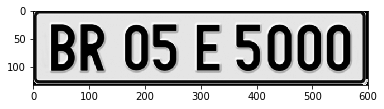

In [42]:
plate = skimage.io.imread('legalplate.png', as_gray=True)
plt.imshow(plate, cmap='gray')

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


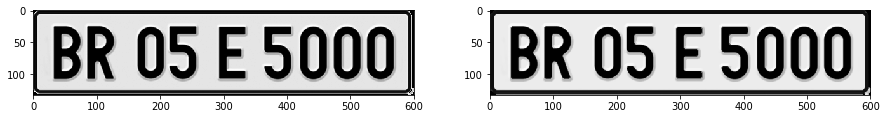

In [43]:
from skimage import filters

plate_denoised = filters.median(plate, selem=np.ones((5,5)))
f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(plate, cmap='gray')
ax1.imshow(plate_denoised, cmap='gray')

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


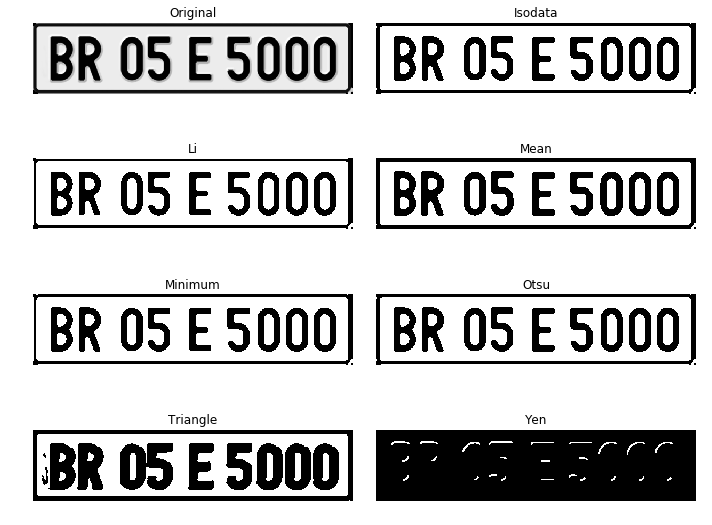

In [44]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(plate_denoised, figsize=(10, 8), verbose=True)
plt.show()

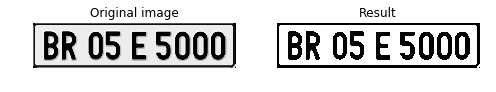

In [45]:
from skimage.filters import threshold_mean, threshold_otsu


thresh = threshold_mean(plate_denoised)
binary = plate_denoised > thresh
otsu = threshold_otsu(plate_denoised)
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(plate_denoised, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

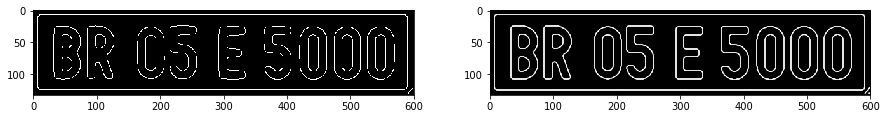

In [46]:
from skimage import feature, filters

edges = skimage.feature.canny(binary, sigma=3)
sobel_edges = skimage.filters.sobel(binary)

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(edges, cmap='gray')
ax1.imshow(sobel_edges, cmap='gray')

Text(0.5, 1.0, 'Euclidian distance')

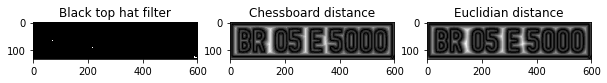

In [47]:
# euclidian distance, chessboard distance and city block (manhattan) distance

from scipy.ndimage import distance_transform_edt, distance_transform_cdt # euclidian distance - distance to closest background pixel
from scipy.ndimage.morphology import black_tophat

euclidian = distance_transform_edt(~edges)
dt = distance_transform_cdt(~edges, metric='chessboard')     # call on negative of edges
blackTopHat = black_tophat(edges, size=(5,5))               # black top hat filter         

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))

ax[0].imshow(blackTopHat, cmap='gray')
ax[0].set_title('Black top hat filter')
ax[1].imshow(dt, cmap='gray')
ax[1].set_title('Chessboard distance')
ax[2].imshow(euclidian, cmap='gray')
ax[2].set_title('Euclidian distance')

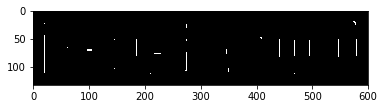

In [50]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=20)
plt.imshow(local_max, cmap='gray')

In [51]:
peak_idx = feature.peak_local_max(dt, indices=True, min_distance=10)
peak_idx[:5]

array([[116, 552],
       [116, 551],
       [116, 550],
       [116, 549],
       [116, 548]])

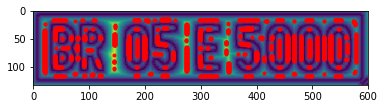

In [52]:
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')
plt.imshow(dt)

In [0]:
from skimage import measure

markers = measure.label(local_max)

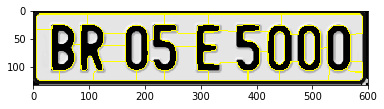

In [54]:
from skimage import morphology, segmentation

labels = morphology.watershed(-dt, markers)     # center of plate becomes trough
plt.imshow(segmentation.mark_boundaries(plate_denoised, labels))

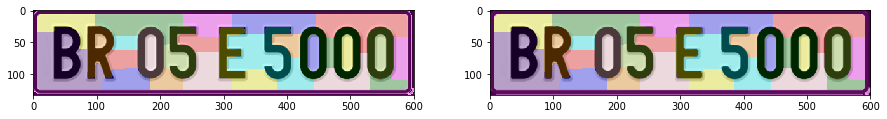

In [55]:
from skimage import color

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(color.label2rgb(labels, image=plate))
ax1.imshow(color.label2rgb(labels, image=plate_denoised))

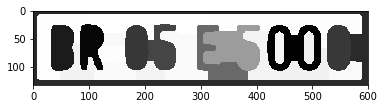

In [56]:
plt.imshow(color.label2rgb(labels, image=plate_denoised, kind='avg'), cmap='gray')

In [0]:
regions = measure.regionprops(labels, intensity_image=plate_denoised)      # list of region properties

(array([ 2.,  0.,  1.,  1.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  3., 17.]),
 array([ 30.82098374,  40.56775476,  50.31452578,  60.06129679,
         69.80806781,  79.55483882,  89.30160984,  99.04838086,
        108.79515187, 118.54192289, 128.2886939 , 138.03546492,
        147.78223593, 157.52900695, 167.27577797, 177.02254898,
        186.76932   , 196.51609101, 206.26286203, 216.00963304,
        225.75640406]),
 <a list of 20 Patch objects>)

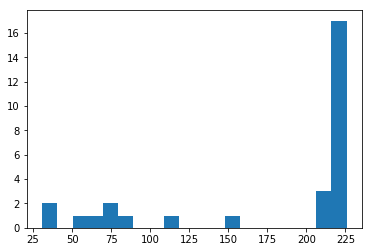

In [58]:
region_means = [r.mean_intensity for r in regions]
plt.hist(region_means, bins=20) 

Depicts background has much less intensity than the numbers. 

In [0]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2)

region_means = np.array(region_means).reshape(-1,1)

In [60]:
region_means

array([[223.00023332],
       [224.25759494],
       [224.14884099],
       [225.75640406],
       [225.30149015],
       [224.60976547],
       [216.49816176],
       [219.60535506],
       [ 72.18611016],
       [ 73.08558262],
       [221.56836077],
       [218.13736264],
       [214.87932844],
       [ 62.94651124],
       [ 30.82098374],
       [ 51.37082658],
       [ 35.71153846],
       [149.78329531],
       [221.43617021],
       [ 83.13375796],
       [223.72617247],
       [221.56436119],
       [111.03620033],
       [220.52888889],
       [220.03578337],
       [215.26441838],
       [216.44032258],
       [216.48277946],
       [214.09742351]])

In [61]:
model.fit(region_means)
print(model.cluster_centers_)

[[ 65.03643889]
 [217.00583395]]


In [62]:
bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1], dtype=int32)

In [0]:
classified_labels = labels.copy()
for bg_fg, region in zip(bg_fg_labels, regions):
  classified_labels[tuple(region.coords.T)] = bg_fg

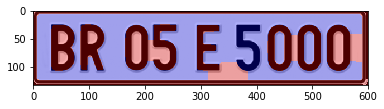

In [64]:
plt.imshow(color.label2rgb(classified_labels, image=plate))

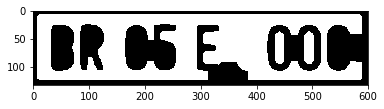

In [65]:
plt.imshow(classified_labels, cmap='gray')

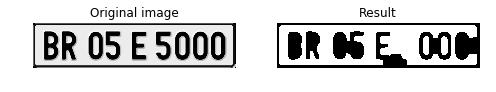

In [66]:
# Another thresholding
from skimage.filters import threshold_mean


thresh = threshold_mean(classified_labels)
binary = classified_labels > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(plate_denoised, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(classified_labels, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

In [67]:
!pip install pytesseract

In [68]:
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 252 kB in 1s (303 kB/s)
Reading package lists... Done
Building dependency tree       
Reading s

In [72]:
import pytesseract

text = pytesseract.image_to_string(plate_denoised, config='--psm 7 -c tessedit_char_whitelist=0123456789.%', lang='eng')
text

'BR 05 £5000)'